In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, log_loss, classification_report, confusion_matrix
from collections import Counter
import xgboost as xgb
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
df = pd.read_csv('Loan_default.csv')

# Drop LoanID as it is not a predictive feature
df.drop('LoanID', axis=1, inplace=True)

# Select features and target variable
features = [
    'Age', 'Income', 'LoanAmount', 'InterestRate', 'Education', 'LoanTerm',
    'MonthsEmployed', 'EmploymentType', 'MaritalStatus', 'HasCoSigner',
    'HasDependents', 'LoanPurpose'
]
X = df[features]
y = df['Default']

# Handle missing values if any
X = X.dropna()
y = y.loc[X.index]

In [3]:
# Map binary categorical variables to numerical values
binary_vars = ['HasCoSigner', 'HasDependents']
for var in binary_vars:
    X[var] = X[var].map({'Yes': 1, 'No': 0})

# Label encode categorical variables
label_encoders = {}
categorical_vars = ['Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose']
for var in categorical_vars:
    le = LabelEncoder()
    X[var] = le.fit_transform(X[var])
    label_encoders[var] = le

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Address class imbalance
counter = Counter(y_train)
scale_pos_weight = counter[0] / counter[1]

In [4]:
# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

In [5]:
# Set up the hyperparameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 10],
    'scale_pos_weight': [1, scale_pos_weight],
}

In [6]:
# Set up cross-validation strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,
    scoring='roc_auc',
    cv=kfold,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/home/dalton/miniconda3/envs/portfolio/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:37:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dalton/miniconda3/envs/portfolio/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:37:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dalton/miniconda3/envs/portfolio/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:37:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dalton/miniconda3/envs/portfolio/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:37:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dalton/miniconda3/envs/portfolio/lib/p

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           imp...
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1],
                                        'gamma': [0, 1, 5],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200],
                                        'reg_alpha': [0, 0.01, 0.1],
                                        'reg_lambda': [1, 10],
                                        'scale_pos_weight': [1,
                                                             7.61128909872692],
                                        'subsample': [0.8, 1]},
                   random_state=42, scoring='roc_auc', verbose=1)

Best parameters found: {'subsample': 1, 'scale_pos_weight': 1, 'reg_lambda': 10, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
ROC AUC Score: 0.7557
Log Loss: 0.3120
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     45139
           1       0.60      0.06      0.11      5931

    accuracy                           0.89     51070
   macro avg       0.75      0.53      0.53     51070
weighted avg       0.86      0.89      0.84     51070

Confusion Matrix:
[[44900   239]
 [ 5568   363]]


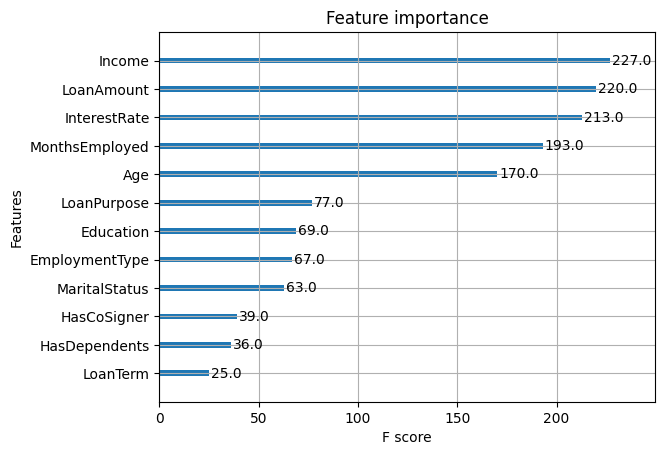

In [7]:
# Retrieve the best model
best_model = random_search.best_estimator_
print(f"Best parameters found: {random_search.best_params_}")

# Evaluate the model on the test set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

logloss = log_loss(y_test, y_pred_proba)
print(f"Log Loss: {logloss:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Plot feature importance
xgb.plot_importance(best_model)
plt.show()

In [8]:
import pickle

# Save the trained model
with open('xgboost_loan_default_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

# Save the label encoders
with open('label_encoders.pkl', 'wb') as file:
    pickle.dump(label_encoders, file)